In [137]:
import numpy as np 
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as c
import pandas as pd 
import sys 
import dask.dataframe as dd 
import time
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import astropy.units as u
from photutils.aperture import CircularAnnulus, CircularAperture
import cv2
from radio_beam import Beam
from matplotlib import cm
from skimage.measure import regionprops, label
from math import pi
import random
import math
from natsort import natsorted

In [33]:
def measure_snr(img, box):
    y0, x0, y1, x1 = box
    xc, yc = 180, 180
    r0, r1 = 1.6 * (x1 - x0), 2.6 * (x1 - x0)
    r = 0.5 * (x1 - x0)

    noise_aperture = CircularAnnulus((xc, yc), r0 / 2, r1 / 2 )
    mask = noise_aperture.to_mask(method='center')

    source_aperture = CircularAperture((xc, yc), r)
    aperture_mask = source_aperture.to_mask()

    noise_p = mask.multiply(img)
    noise_p = noise_p[mask.data > 0]
    source_p = aperture_mask.multiply(img)
    source_p = source_p[aperture_mask.data > 0.]
    std = np.std(noise_p)
    mean = np.mean(source_p)
    snr = mean / std
    #print('Source Mean: ', mean)
    #print('Noise RMS: ', std)
    return snr
    
def generate_noise(rms):
    ch, rows, cols = 128, 360, 360
    mean = 0
    gauss = np.random.normal(mean, rms, (ch, rows, cols))
    return gauss

def add_noise(cube, rms):
    bmaj = 0.886 * u.arcsec
    bmin = 0.7691 * u.arcsec
    noise = generate_noise(rms)
    pix_scale = 0.1 * u.arcsec
    gk = np.array(Beam(bmaj, bmin).as_kernel(pix_scale))
    noisy_cube = np.zeros(cube.shape)
    for z in range(cube.shape[0]):
        noisy_cube[z] = cube[z] + cv2.filter2D(noise[z], -1, gk)
    return noisy_cube


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

    

In [45]:
def threedgaussian(amplitude, spind, chan, center_x, center_y, width_x, width_y, angle, idxs):
    angle = pi/180. * angle
    rcen_x = center_x * np.cos(angle) - center_y * np.sin(angle)
    rcen_y = center_x * np.sin(angle) + center_y * np.cos(angle)
    xp = idxs[0] * np.cos(angle) - idxs[1] * np.sin(angle)
    yp = idxs[0] * np.sin(angle) + idxs[1] * np.cos(angle)
    v1 = 230e9 - (64 * 10e6)
    v2 = v1+10e6*chan

    g = (10**(np.log10(amplitude) + (spind) * np.log10(v1/v2))) * np.exp(-(((rcen_x-xp)/width_x)**2+((rcen_y-yp)/width_y)**2)/2.)
    return g

def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    level: level
    """
    return amp*np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))

def generate_component(master_cube, boxes, amp, line_amp, pos_x, pos_y, fwhm_x, fwhm_y, pos_z, fwhm_z, pa, spind):
    z_idxs = np.arange(0, 128)
    idxs = np.indices([360, 360])
    g = gaussian(z_idxs, line_amp, pos_z, fwhm_z)
    cube = np.zeros((128, 360, 360))
    for z in range(cube.shape[0]):
        ts = threedgaussian(amp, spind, z, pos_x, pos_y, fwhm_x, fwhm_y, pa, idxs)
        cube[z] += ts + g[z] * ts
    img = np.sum(cube, axis=0)
    tseg = (img - np.min(img)) / (np.max(img) - np.min(img))
    std = np.std(tseg)
    tseg[tseg >= 3 * std] = 1
    tseg = tseg.astype(int)
    
    props = regionprops(label(tseg, connectivity=2))
    y0, x0, y1, x1 = props[0].bbox
    boxes.append([y0, x0, y1, x1])
    master_cube += cube
    return master_cube

In [47]:
xyposs = np.arange(100,250).astype(float)
fwhms = np.linspace(2.,8.,num=100).astype(float)
angles = np.linspace(0,90,num=100).astype(float)
line_centres = np.arange(10, 110).astype(float)
line_fwhms = np.linspace(3, 10, num=100).astype(float)
spectral_indexes = np.linspace(-2, 2, num=100).astype(float)
amps = np.arange(1, 5, 0.1)
i = 0

In [115]:
class Bbox:
    def __init__(self, y1, x1, y2, x2):
        self.x1 = max(x1, x2)
        self.x2 = min(x1, x2)
        self.y1 = max(y1, y2)
        self.y2 = max(y1, y2)
        self.box = [self.x1, self.y1, self.x2, self.y2]
        self.width = abs(self.x1 - self.x2)
        self.height = abs(self.y1 - self.y2)

    @property
    def area(self):
        """
        Calculates the surface area. useful for IOU!
        """
        return (self.x2 - self.x1 + 1) * (self.y2 - self.y1 + 1)

    def intersect(self, bbox):
        x1 = max(self.x1, bbox.x1)
        y1 = max(self.y1, bbox.y1)
        x2 = min(self.x2, bbox.x2)
        y2 = min(self.y2, bbox.y2)
        intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
        return intersection

    def iou(self, bbox):
        intersection = self.intersection(bbox)

        iou = intersection / float(self.area + bbox.area - intersection)
        # return the intersection over union value
        return iou

def genpt(posxy):
    return (random.choice(posxy), random.choice(posxy))

def distance(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)



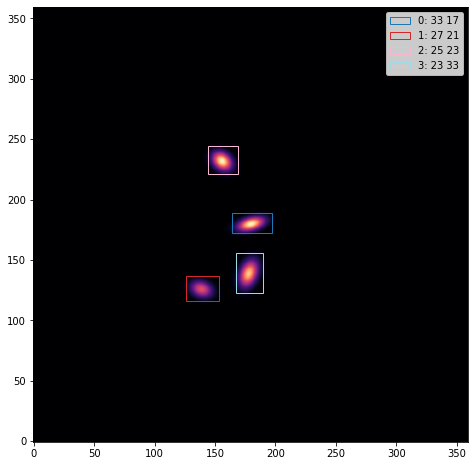

In [133]:
params = []
pa = np.random.choice(angles)
amp = np.random.choice(amps)
line_amp = np.random.choice(amps)
limit = amp + line_amp * amp
pos_x, pos_y = 180, 180
pos_z = np.random.choice(line_centres)
fwhm_z = np.random.choice(line_fwhms)
fwhm_x = np.random.choice(fwhms)
fwhm_y = np.random.choice(fwhms)
spind = np.random.choice(spectral_indexes)
master_cube = np.zeros((128, 360, 360))
boxes = []
master_cube = generate_component(master_cube, boxes, amp, line_amp, pos_x, pos_y, fwhm_x, fwhm_y, pos_z, fwhm_z, pa, spind)
params.append([int(i), round(amp, 2), round(line_amp, 2), round(pa, 2), round(spind, 2), 
                       round(fwhm_x, 2), round(fwhm_y, 2), round(fwhm_z, 2), round(pos_z, 2)])

n_components = random.randint(2, 5)
mindist = 20
sample = []

while len(sample) < n_components:
   newp = genpt(xyposs)
   for p in sample:
      if distance(newp,p) < mindist: break
   else:
     sample.append(newp)

for j in range(n_components):
    pos_x = sample[j][0]
    pos_y =  sample[j][1]
    fwhm_x = np.random.choice(fwhms)
    fwhm_y = np.random.choice(fwhms)  
    pa = np.random.choice(angles)
    spidx = np.random.choice(spectral_indexes)
    pos_z = np.random.choice(line_centres)
    fwhm_z = np.random.choice(line_fwhms)
    temp = 99
    while temp > limit:
        amp = np.random.choice(amps)
        line_amp = np.random.choice(amps)
        temp = amp + line_amp * amp
    master_cube = generate_component(master_cube, boxes, amp, line_amp, pos_x, pos_y, fwhm_x, fwhm_y, pos_z, fwhm_z, pa, spind)
    params.append([int(i), round(amp, 2), round(line_amp, 2), round(pa, 2), round(spind, 2), 
                       round(fwhm_x, 2), round(fwhm_y, 2), round(fwhm_z, 2), round(pos_z, 2)])
boxes = np.array(boxes)
img = np.sum(master_cube, axis=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(img, origin="lower", cmap="magma")
cmap = get_cmap(len(boxes), name="tab20")
for j, box in enumerate(boxes):
    rect = patches.Rectangle(xy=(box[1], box[0]), 
            width=box[3] - box[1],
            height=box[2] - box[0], 
            facecolor="none",
            edgecolor=cmap(j),
            label=str(j) + ": {} {}".format(str(box[3] - box[1]), str(box[2] - box[0])) )
    ax.add_patch(rect)
plt.legend()
plt.show()



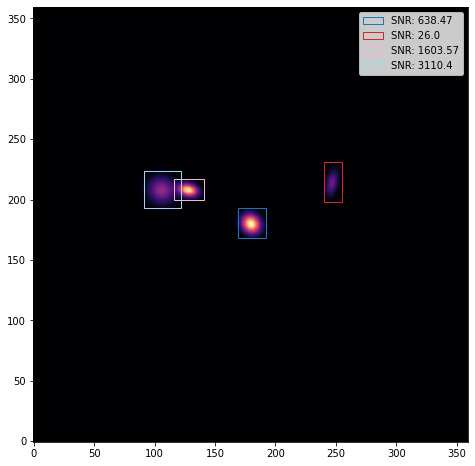

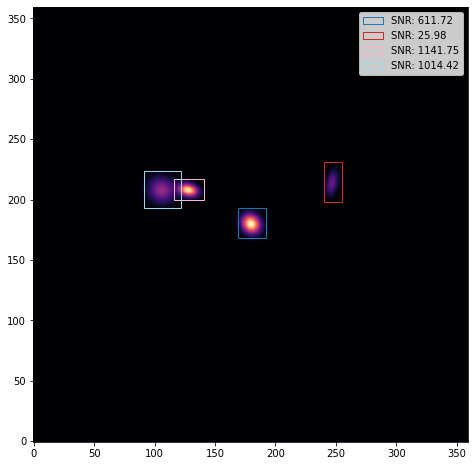

In [125]:
input_dir = "models"
output_dir = "sims"
catalogue_name = "params.csv"
input_dataframe = pd.read_csv(os.path.join(input_dir, catalogue_name))
i = 0
source_params = input_dataframe.loc[input_dataframe.ID == i]
boxes = np.array(source_params[["y0", "x0", "y1", "x1"]].values)
cube = fits.getdata(os.path.join(input_dir, "gauss_cube_{}.fits".format(str(i))))
img = np.sum(cube, axis=0)


cmap = get_cmap(len(boxes), name="tab20")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
plt.imshow(img, origin="lower", cmap="magma")
viridis = cm.get_cmap('viridis', len(boxes))
for i, box in enumerate(boxes):
    snr = measure_snr(img, box)
    rect = patches.Rectangle(xy=(box[1], box[0]), 
                    width=box[3] - box[1],
                    height=box[2] - box[0], 
                    facecolor="none",
                    edgecolor=cmap(i),
                    label='SNR: ' + str(round(snr, 2)))
    ax.add_patch(rect)
plt.legend()
plt.show()

noisy_cube = add_noise(cube, 0.15)
img = np.sum(noisy_cube, axis=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
plt.imshow(img, origin="lower", cmap="magma")
viridis = cm.get_cmap('viridis', len(boxes))
for i, box in enumerate(boxes):
    snr = measure_snr(img, box)
    rect = patches.Rectangle(xy=(box[1], box[0]), 
                    width=box[3] - box[1],
                    height=box[2] - box[0], 
                    facecolor="none",
                    edgecolor=cmap(i),
                    label='SNR: ' + str(round(snr, 2)))
    ax.add_patch(rect)
plt.legend()
plt.show()



models
[[39.    5.4 ]
 [88.    9.43]
 [27.    6.11]]


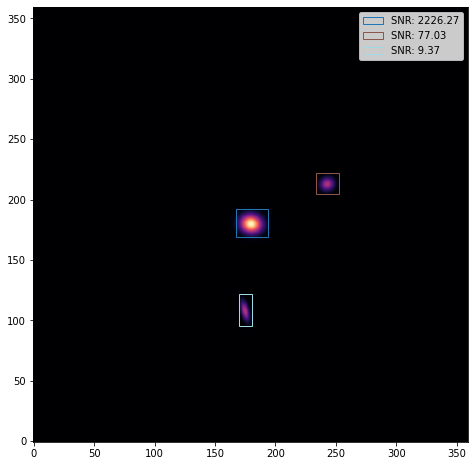

[[104.     6.68]
 [ 28.     8.23]
 [ 82.     6.32]
 [ 97.     9.36]]


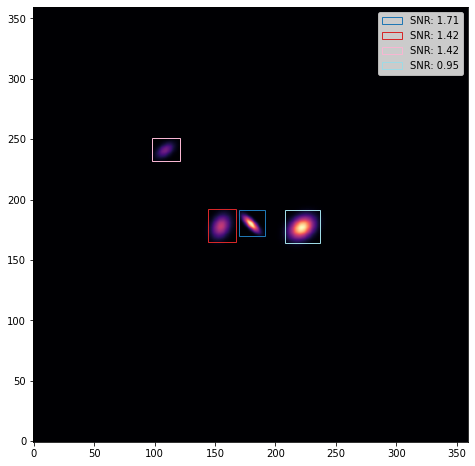

[[42.    9.36]
 [47.    5.83]
 [44.    4.41]
 [48.    8.59]
 [86.    8.52]]


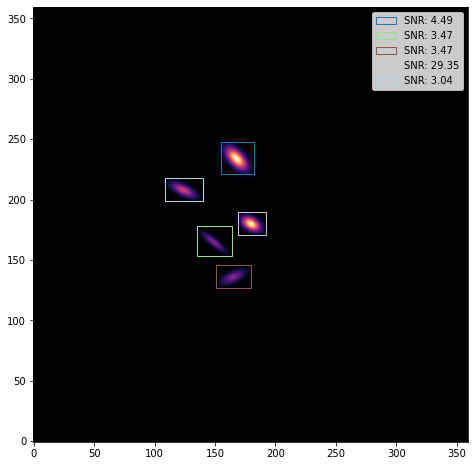

[[26.    7.24]
 [52.    4.84]
 [46.    5.4 ]
 [51.    4.98]
 [22.    7.95]]


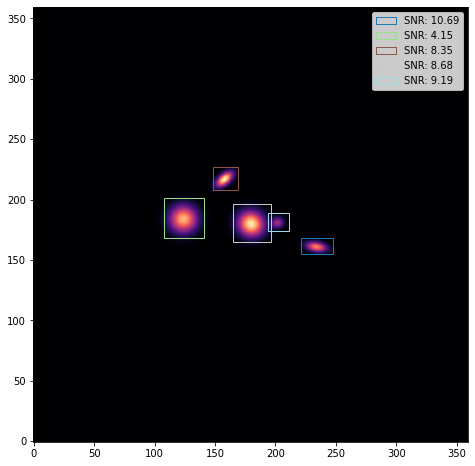

[[100.     9.36]
 [ 25.     8.37]
 [ 43.     3.49]
 [ 98.     4.2 ]]


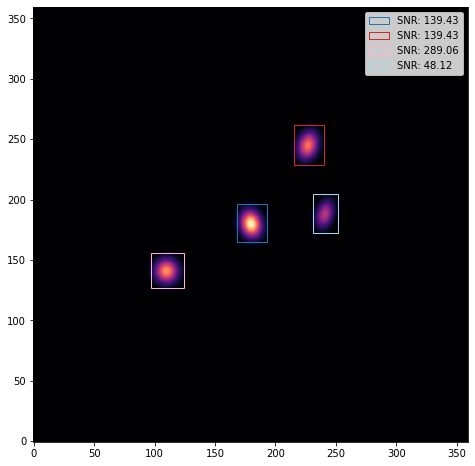

[[60.    5.12]
 [56.    4.56]
 [24.    6.68]
 [88.    4.63]]


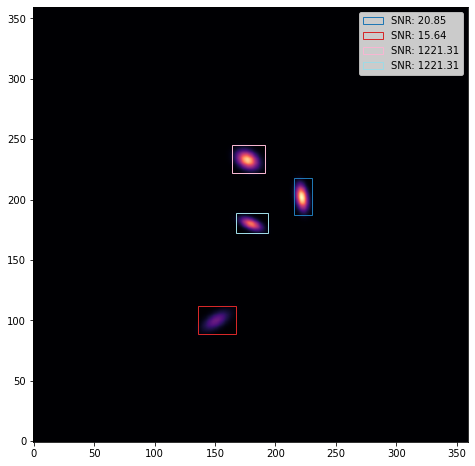

[[109.     5.12]
 [ 35.     5.4 ]
 [ 77.     7.45]]


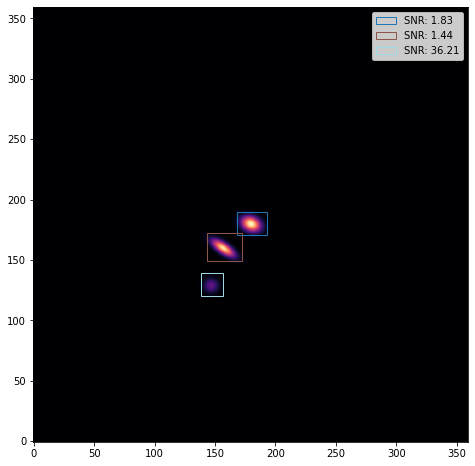

[[86.    5.9 ]
 [48.    5.62]
 [26.    7.45]
 [97.    7.45]
 [30.    5.55]
 [52.    7.45]]


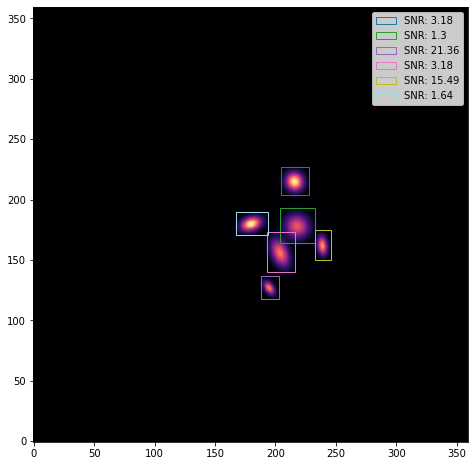

[[ 84.     8.59]
 [ 71.     3.42]
 [105.     9.22]]


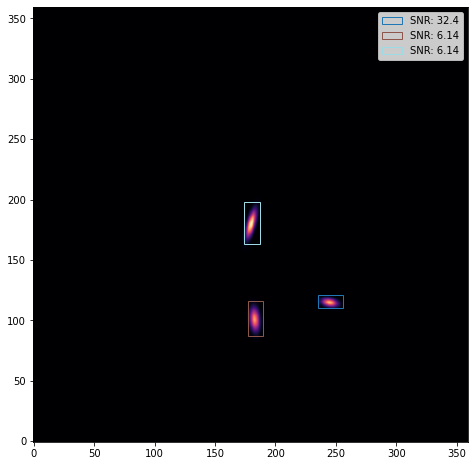

[[53.    9.51]
 [13.    8.16]
 [74.    9.29]
 [69.    8.37]
 [34.    3.85]]


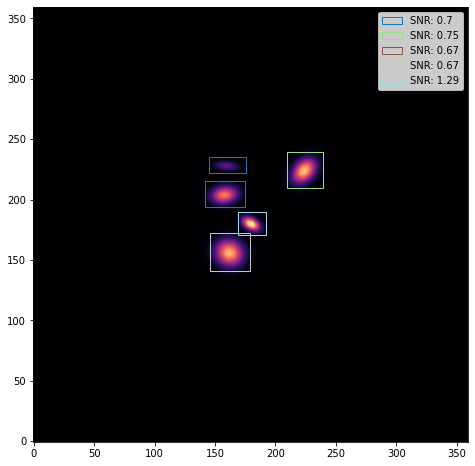

[[53.    9.15]
 [14.    7.81]
 [77.    7.53]
 [98.    6.11]]


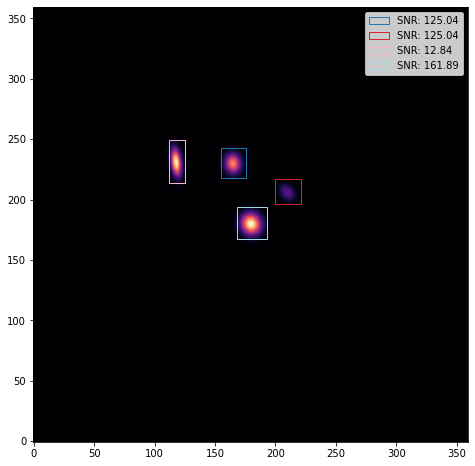

[[21.    3.49]
 [70.    3.99]
 [77.    7.6 ]
 [66.    6.32]
 [49.    9.15]
 [20.    5.9 ]]


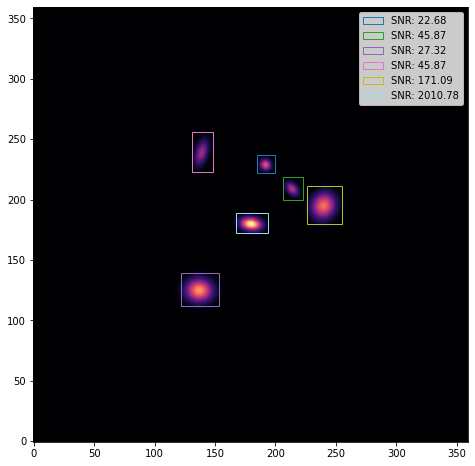

[[ 96.     9.29]
 [105.     4.34]
 [ 29.     8.16]
 [ 15.     8.73]
 [ 87.     7.24]
 [ 35.     7.74]]


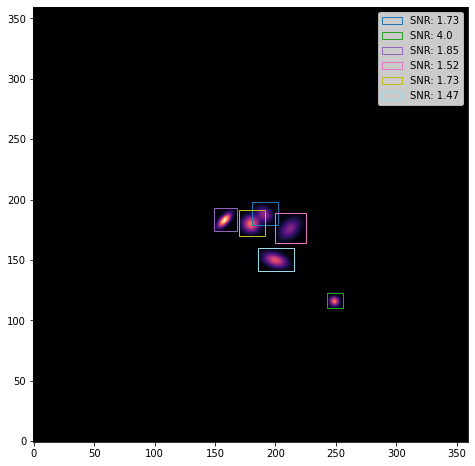

[[ 27.     6.54]
 [103.     8.37]
 [ 69.     7.88]
 [ 95.     7.67]
 [ 95.     3.71]]


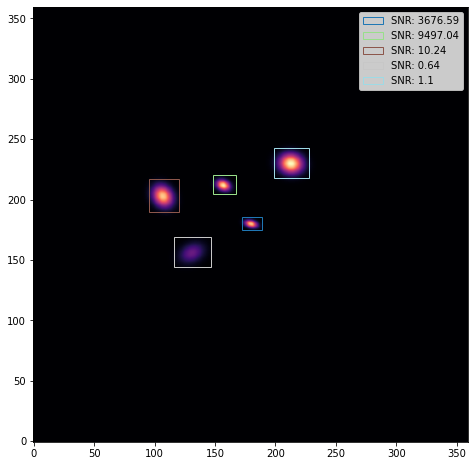

[[43.    8.52]
 [17.    6.68]
 [31.    8.73]]


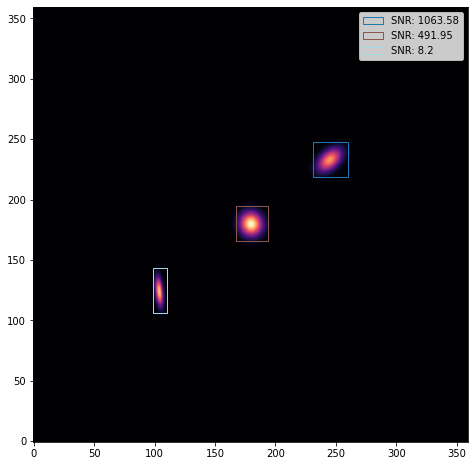

[[27.    5.12]
 [84.    8.23]
 [24.    6.61]
 [60.    7.1 ]
 [70.    4.13]
 [97.    9.72]]


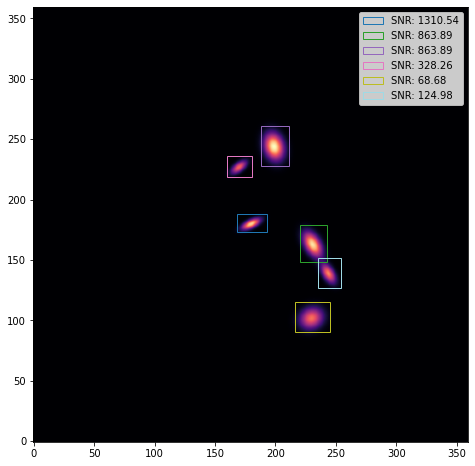

In [138]:
def snr_extractor(input_dir, output_dir):
    catalogue_name = "params.csv"
    input_dataframe = pd.read_csv(os.path.join(input_dir, catalogue_name))
    filelist = natsorted(list([file for file in os.listdir(input_dir) if "gauss" in file]))
    snrs = []
    for i, file in enumerate(filelist):
        source_params = input_dataframe.loc[input_dataframe.ID == i]
        boxes = np.array(source_params[["y0", "x0", "y1", "x1"]].values)
        spectral_info = np.array(source_params[["z", "fwhm_z"]].values)
        print(spectral_info)
        cube = fits.getdata(os.path.join(input_dir, file))
        img = np.sum(cube, axis=0)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
        ax.imshow(img, origin="lower", cmap="magma")
        cmap = get_cmap(len(boxes), name="tab20")
        for j, box in enumerate(boxes):
            snr = measure_snr(img, box)
            snrs.append(round(snr, 2))
            rect = patches.Rectangle(xy=(box[1], box[0]), 
                    width=box[3] - box[1],
                    height=box[2] - box[0], 
                    facecolor="none",
                    edgecolor=cmap(j),
                    label='SNR: ' + str(round(snr, 2)))
            ax.add_patch(rect)
        plt.legend()
        plt.show()
            
    return snrs, input_dataframe

print(input_dir)
snrs, params = snr_extractor(input_dir, output_dir)

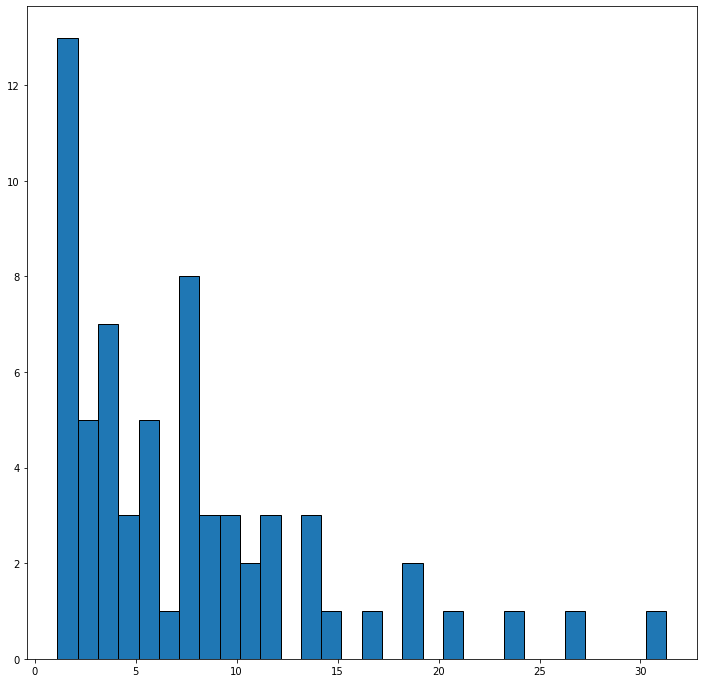

7.701093749999999


In [40]:
plt.figure(figsize=(12, 12))
plt.hist(snrs, edgecolor="black", bins=30)
plt.show()
print(np.mean(snrs))